## janesick_nature_comms_2023

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import concord as ccd
import scanpy as sc
import torch
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
import time
from pathlib import Path
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
seed = 0

In [3]:
import time
from pathlib import Path
proj_name = "janesick_alltech"
file_name = proj_name
file_suffix = time.strftime('%b%d-%H%M')
seed = 0

save_dir = Path(f"../save/{proj_name}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)


### Load corresponding adata

In [4]:
import scanpy as sc
scRNA_adata = sc.read_h5ad(data_dir / "scRNA_adata_Jun06-1218.h5ad")
xenium_adata = sc.read_h5ad(data_dir / "xenium_adata_Jun05-1233.h5ad")

/wynton/home/gartner/zhuqin/.conda/envs/cellpath/lib/python3.9/site-packages/matplotlib_venn/_venn2.py:162: UserWarning: normalize_to is deprecated. Please use layout_algorithm=matplotlib_venn.layout.venn2.DefaultLayoutAlgorithm(normalize_to) instead.
  warnings.warn(


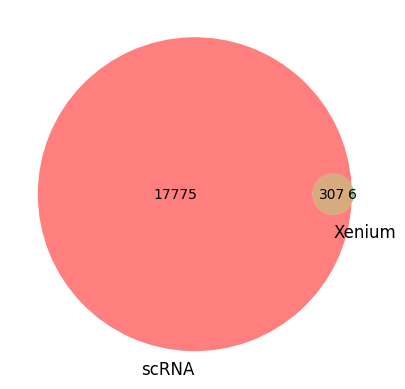

In [5]:
# Check gene overlap with venn diagram
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
genes = [set(scRNA_adata.var_names), set(xenium_adata.var_names)]
venn2(genes, 
      set_labels=('scRNA', 'Xenium'),
      alpha=0.5,
      normalize_to=1.0,
      ax=None)
plt.savefig(save_dir / f"venn_genes_{file_suffix}.png")
plt.show()
plt.close()

In [6]:

adata = scRNA_adata.concatenate(xenium_adata)
adata.shape

/scratch/zhuqin/ipykernel_2868564/4153262838.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = scRNA_adata.concatenate(xenium_adata)


(352254, 307)

In [7]:
# Filter out cells with too few genes
sc.pp.filter_cells(adata, min_genes=10)
print(f"Cells after filtering: {adata.shape[0]}")

Cells after filtering: 337958


In [9]:
# Normalize visium_adata
adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
# log transform
sc.pp.log1p(adata)

In [11]:
xenium_idx = adata.obs_names.str.startswith('xenium')
adata.obs['Technology'] = adata.obs['Technology'].astype('str')
adata.obs.loc[xenium_idx, 'Technology'] = 'xenium'
adata.obs['Technology'].value_counts()

Technology
xenium    281694
FRP        29554
P5         18031
P3          8679
Name: count, dtype: int64

In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat_v3', subset=False)
adata = adata[:, adata.var.highly_variable].copy()
adata.write_h5ad(data_dir / f"{file_name}_preprocessed_HVG.h5ad")
print(f"✅ Preprocessed data saved to {data_dir / f'{file_name}_preprocessed_HVG.h5ad'}")

/wynton/home/gartner/zhuqin/.conda/envs/cellpath/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


✅ Preprocessed data saved to ../data/janesick_alltech/janesick_alltech_preprocessed_HVG.h5ad


### Generate jobs

In [4]:
import subprocess, json
py_methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "concord_knn", "contrastive"]
output_dir = '../jobs'
device = 'auto'
conda_env = 'cellpath'
batch_key = 'Technology'
state_key = 'None'
latent_dim = '50'  # Adjust as needed, but should match the encoder_dims in concord_args
subprocess.run([
    "python", "./generate_py_jobs.py",
    "--proj_name", proj_name,
    "--adata_filename", f"{file_name}_preprocessed_HVG.h5ad",
    "--methods", *py_methods,
    "--batch_key", batch_key,
    "--state_key", state_key,
    "--latent_dim", latent_dim,
    "--output_dir", output_dir,
    "--device", device,
    "--mem", "32G",  # Adjust memory as needed
    "--conda_env", conda_env,
    "--runtime", "3:00:00",
    "--mode", "wynton"
])


✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_scvi.py
✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_scvi.sh

✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_harmony.py
✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_harmony.sh

✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_scanorama.py
✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_scanorama.sh

✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_liger.py
✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_liger.sh

✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_unintegrated.py
✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_unintegrated.sh

✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_concord_hcl.py
✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_concord_hcl.sh

✅ Generated: benchmark_janesick_alltech/benchm

CompletedProcess(args=['python', './generate_py_jobs.py', '--proj_name', 'janesick_alltech', '--adata_filename', 'janesick_alltech_preprocessed_HVG.h5ad', '--methods', 'scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive', '--batch_key', 'Technology', '--state_key', 'None', '--latent_dim', '50', '--output_dir', '../jobs', '--device', 'auto', '--mem', '32G', '--conda_env', 'cellpath', '--runtime', '3:00:00', '--mode', 'wynton'], returncode=0)

In [16]:
ccd.ul.anndata_to_viscello(adata,
                        output_dir=data_dir / f"viscello_{proj_name}",
                        project_name=proj_name,
                        organism='hsa')

VisCello project created at ../data/janesick_alltech/viscello_janesick_alltech


In [17]:
# Generate script for Seurat
import subprocess
r_methods = ["seurat_cca", "seurat_rpca"]
output_dir = '../jobs'
device = 'auto'
subprocess.run([
    "python", "./generate_seurat_script.py",
    "--proj_name", proj_name,
    "--eset_dir", '../'+ str(data_dir / f"viscello_{proj_name}"),   # <- folder w/ eset.rds
    "--methods", *r_methods,
    "--batch_key", batch_key,
    "--state_key", state_key,
    "--latent_dim", latent_dim,
    "--mem", "120G",  # Adjust memory as needed
    "--runtime", "48:00:00",
    "--output_dir", output_dir,
    "--device", device,
    "--conda_env", conda_env
])

✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_seurat_cca.R
✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_seurat_cca.sh

✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_seurat_rpca.R
✅ Generated: benchmark_janesick_alltech/benchmark_janesick_alltech_seurat_rpca.sh



CompletedProcess(args=['python', './generate_seurat_script.py', '--proj_name', 'janesick_alltech', '--eset_dir', '../../data/janesick_alltech/viscello_janesick_alltech', '--methods', 'seurat_cca', 'seurat_rpca', '--batch_key', 'Technology', '--state_key', 'None', '--latent_dim', '50', '--mem', '120G', '--runtime', '48:00:00', '--output_dir', '../jobs', '--device', 'auto', '--conda_env', 'cellpath'], returncode=0)

In [18]:
proj_folder = Path(output_dir) / f"benchmark_{proj_name}"   # ../jobs/benchmark_<proj>
proj_folder.mkdir(exist_ok=True)                      # defensive

submit_all = proj_folder / f"submit_all_{proj_name}.sh"
with submit_all.open("w") as f:
    f.write("#!/bin/bash\n")
    f.write("# Auto-generated — submits every job for this project\n")
    f.write("# Run from this folder, or let the script cd into it.\n\n")
    f.write('cd "$(dirname "$0")"\n\n')          # ensures we’re in the right dir
    for sh_file in sorted(proj_folder.glob(f"benchmark_{proj_name}_*.sh")):
        f.write(f'qsub "{sh_file.name}"\n')

submit_all.chmod(0o755)
print(f"📌  Run “{submit_all}” to queue every job.")

📌  Run “../jobs/benchmark_janesick_alltech/submit_all_janesick_alltech.sh” to queue every job.
